# Dogs vs Cat Redux

In this tutorial, you will learn how generate and submit predictions to a Kaggle competiton

[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)
    
    

To start you will need to download and unzip the competition data from Kaggle and ensure your directory structure looks like this
```
utils/
    vgg16.py
    utils.py
lesson1/
    redux.ipynb
    data/
        redux/
            train/
                cat.437.jpg
                dog.9924.jpg
                cat.1029.jpg
                dog.4374.jpg
            test/
                231.jpg
                325.jpg
                1235.jpg
                9923.jpg
```

You can download the data files from the competition page [here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) or you can download them from the command line using the [Kaggle CLI](https://github.com/floydwch/kaggle-cli).

You should launch your notebook inside the lesson1 directory
```
cd lesson1
jupyter notebook
```

In [1]:
from __future__ import division, print_function

#Verify we are in the lesson1 directory
%pwd

'F:\\tools\\projects\\fast.ai.learning\\lesson1'

In [2]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'\\data\\redux'

In [3]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
from vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

# Change set the image dim ordering
from keras import backend as K
import os, importlib

# set backend for keras
# def set_keras_backend(backend):
#     if K.backend() != backend:
#         os.environ['KERAS_BACKEND'] = backend
#         importlib.reload(K)
        #assert K.backend() == backend

# set theano as backend
# set_keras_backend("theano")

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 

987 
988 PyObject * CudaNdarray_View(const CudaNdarray * self)
989 {
990     CudaNdarray * rval = (CudaNdarray*)CudaNdarray_New(self->nd);
991     if (!rval || CudaNdarray_set_device_data(rval, CudaNdarray_DEV_DATA(self), self))
992     {
993         Py_XDECREF(rval);
994         rval = NULL;
995     }
996     else
997     {
998         for (int i = 0; i < self->nd; ++i)
999         {
1000             CudaNdarray_set_dim(rval, i, CudaNdarray_HOST_DIMS(self)[i]);
1001             CudaNdarray_set_stride(rval, i, CudaNdarray_HOST_STRIDES(self)[i]);
1002         }
1003     }
1004     return (PyObject*)rval;
1005 }
1006 
1007 /*
1008  * d0,... are the output dims
1009  * indices are a list of index to operate on
1010  *         They are int32 viewed as float32.
1011  * a is the output
1012  * b is the input
1013  * dB0, the source leading dimensions size
1014  */
1015 template <int operator_num>
1016 __global__ void k_take_3(const int d0, const int d1, const int d2,
1017                    

1736 
1737     //broadcast to the same number of dimensions.
1738     int* other_dims = (int*) alloca(self->nd * sizeof(int));
1739     int* other_strides = (int*) alloca(self->nd * sizeof(int));
1740     int added_dims = self->nd - other->nd;
1741     // Add the added broadcasted dimensions
1742     for (int i = 0; i< added_dims; ++i)
1743     {
1744         other_dims[i] = 1;
1745         other_strides[i] = 0;
1746     }
1747     // Copy the existing dimensions
1748     for (int i = 0; i< other->nd; ++i)
1749     {
1750         other_dims[i+added_dims] = CudaNdarray_HOST_DIMS(other)[i];
1751         other_strides[i+added_dims] = CudaNdarray_HOST_STRIDES(other)[i];
1752     }
1753 
1754     //standard elemwise dim checks
1755     unsigned int size = 1;
1756     for (int i = 0; i< self->nd; ++i)
1757     {
1758         if ((CudaNdarray_HOST_DIMS(self)[i] != other_dims[i])
1759             && (other_dims[i] != 1))
1760         {
1761             PyErr_SetString(
1762                 PyE

2486     if (py_rval)
2487     {
2488         if (verbose) fprint_CudaNdarray(stderr, self);
2489         if (verbose) fprint_CudaNdarray(stderr, rval);
2490     }
2491     else
2492     {
2493         PyErr_SetString(PyExc_NotImplementedError, "Unknown key type");
2494         return NULL;
2495     }
2496     return py_rval;
2497 }
2498 
2499 // Will by called by __setitem__ in Python
2500 // See http://docs.python.org/dev/py3k/c-api/object.html#PyObject_SetItem
2501 // Doesn't handle broadcasting, e.g. a[:] = 5
2502 // Can only be assigned from a CudaNdarray on the right side
2503 // Or a ndarray
2504 // Or a python scalar with value 0 when the left side part is c contiguous.
2505 static int
2506 CudaNdarray_setitem(PyObject *o, PyObject  *key, PyObject  *value)
2507 {
2508     int verbose = 0;
2509     if (verbose) fprintf(stderr, "CudaNdarray_setitem start\n");
2510     // We try to copy directly into this CudaNdarray from the ndarray
2511     CudaNdarray* rval = (CudaNdarray*)Cuda

3236                                 cudaGetErrorString(cudaGetLastError()));
3237         }
3238         if (cublas_init() == -1)
3239             return NULL;
3240     }
3241     if(card_number_provided && g_use_cnmem) {
3242         size_t mem = 0;
3243         if (cnmem > 1)
3244             mem = cnmem * 1024 * 1024;
3245         else{
3246             // Clip to 95% to let memory for the driver.
3247             // 98% didn't worked in some cases.
3248             if (cnmem > .95){
3249                 cnmem = .95;
3250             }
3251             size_t free = 0, total = 0;
3252             cudaError_t err = cudaMemGetInfo(&free, &total);
3253             if (err != cudaSuccess){
3254                 // Clear the error flag, cudaMemGetInfo doesn't do it.
3255                 // Currently this returns the same thing as err, but if in future
3256                 // it returns something else I still don't see why we should ignore
3257                 // it.  All we want to do he

3986                 assert(0);
3987             }; break;
3988         case 1: // vector
3989             {
3990                 if (verbose) fprintf(stderr, "Copying non-contiguous vector\n");
3991                 if (verbose) fprint_CudaNdarray(stderr, other);
3992                 unsigned int n_blocks = std::min(size,
3993                                                  (unsigned int)NUM_VECTOR_OP_BLOCKS);
3994                 unsigned int n_threads = std::min(ceil_intdiv(size, n_blocks),
3995                                                   (unsigned int)NUM_VECTOR_OP_THREADS_PER_BLOCK);
3996                 k_copy_1d<<<n_blocks, n_threads>>>(size,
3997                                             CudaNdarray_DEV_DATA(other),
3998                                             CudaNdarray_HOST_STRIDES(other)[0],
3999                                             CudaNdarray_DEV_DATA(self),
4000                                             CudaNdarray_HOST_STRIDES(self)[0]);
4001       

4735                                 }
4736                                 else
4737                                 {
4738                                     pos_d = (reduce_ii & ((1 << log2_dims_a[rd])-1)); //take the lower log2_dims bits
4739                                     reduce_ii = (reduce_ii >> log2_dims_a[rd]);  //shift those lower log2_dims bits off of ii
4740                                 }
4741                                 a_data_ri += pos_d * a_str[rd];
4742                             }
4743                         }
4744                         sum += a_data_ri[0];
4745                     }
4746                 }
4747         }
4748         z_data_i[0] = sum;
4749     }
4750 }
4751 
4752 static __global__ void kernel_reduce_sum_1011(
4753         const unsigned int d0,
4754         const unsigned int d1,
4755         const unsigned int d2,
4756         const unsigned int d3,
4757         const float *A, const int sA0, const int sA1, const int sA2, const int s

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavailable)


nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
nvcc fatal   : Cannot find compiler 'cl.exe' in PATH

['nvcc', '-shared', '-O3', '-use_fast_math', '-Xlinker', '/DEBUG', '-D HAVE_ROUND', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD', '-I"F:\\tools\\Anaconda3\\envs\\deep_learn\\lib\\site-packages\\theano\\sandbox\\cuda"', '-I"F:\\tools\\Anaconda3\\envs\\deep_learn\\lib\\site-packages\\numpy\\core\\include"', '-I"F:\\tools\\Anaconda3\\envs\\deep_learn\\include"', '-I"F:\\tools\\Anaconda3\\envs\\deep_learn\\lib\\site-packages\\theano\\gof"', '-L"F:\\tools\\Anaconda3\\envs\\deep_learn\\libs"', '-L"F:\\tools\\Anaconda3\\envs\\deep_learn"', '-o', 'C:\\Users\\Dell\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-3.6.3-64\\

Using TensorFlow backend.


## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

In [4]:
print (K.backend())

tensorflow


In [5]:
K.set_image_dim_ordering('tf')

In [6]:
K.set_image_data_format('channels_first')

In [7]:
print (K.image_data_format())

channels_first


## Create validation set and sample

In [ ]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir sample\\train
%mkdir sample\\test
%mkdir sample\\valid
%mkdir sample\\results
%mkdir test\\unknown

In [ ]:
%cd $DATA_HOME_DIR\\train

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'\\valid\\' + shuf[i])

In [ ]:
from shutil import copyfile

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'\\sample\\train\\' + shuf[i])

In [ ]:
%cd $DATA_HOME_DIR\\valid

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'\\sample\\valid\\' + shuf[i])

## Rearrange image files into their respective directories

In [ ]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR\\sample\\train
%mkdir cats
%mkdir dogs
!move cat*.jpg cats/
!move dog*.jpg dogs/

%cd $DATA_HOME_DIR\\sample\\valid
%mkdir cats
%mkdir dogs
!move cat*.jpg cats/
!move dog*.jpg dogs/

%cd $DATA_HOME_DIR\\valid
%mkdir cats
%mkdir dogs
!move cat*.jpg cats/
!move dog*.jpg dogs/

%cd $DATA_HOME_DIR\\train
%mkdir cats
%mkdir dogs
!move cat*.jpg cats/
!move dog*.jpg dogs/

In [ ]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR\\test
!move *.jpg unknown/

## Finetuning and Training

In [8]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '\\' #'/sample/'
test_path = DATA_HOME_DIR + '\\test\\' #We use all the test data
results_path=DATA_HOME_DIR + '\\results\\'
train_path=path + '\\train\\'
valid_path=path + '\\valid\\'

print (path, test_path, results_path, train_path, valid_path)

F:\tools\projects\fast.ai.learning\lesson1\data\redux
F:\tools\projects\fast.ai.learning\lesson1\data\redux\ F:\tools\projects\fast.ai.learning\lesson1\data\redux\test\ F:\tools\projects\fast.ai.learning\lesson1\data\redux\results\ F:\tools\projects\fast.ai.learning\lesson1\data\redux\\train\ F:\tools\projects\fast.ai.learning\lesson1\data\redux\\valid\


In [9]:
#import Vgg16 helper class
vgg = Vgg16()

In [10]:
#Set constants. You can experiment with no_of_epochs to improve the model
# batch_size=64
batch_size=4
no_of_epochs=3

In [11]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 21000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [12]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print("Running epoch: %d" % epoch)
    vgg.fit(batches, val_batches, batch_size, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations" % no_of_epochs)

Running epoch: 0
Epoch 1/1
5250/5250 [==============================] - 3876s 738ms/step - loss: 2.0836 - acc: 0.8599 - val_loss: 2.5500 - val_acc: 0.8350
Running epoch: 1
Epoch 1/1
5250/5250 [==============================] - 3875s 738ms/step - loss: 1.9892 - acc: 0.8728 - val_loss: 2.0492 - val_acc: 0.8695
Running epoch: 2
Epoch 1/1
5250/5250 [==============================] - 3719s 708ms/step - loss: 1.8907 - acc: 0.8795 - val_loss: 2.1661 - val_acc: 0.8635
Completed 3 fit operations


## Generate Predictions

Let's use our new model to make predictions on the test dataset

In [13]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [14]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print(preds[:5])

filenames = batches.filenames
print(filenames[:5])

[[  0.0000e+00   1.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  0.0000e+00   1.0000e+00]
 [  1.3549e-37   1.0000e+00]]
['unknown\\1.jpg', 'unknown\\10.jpg', 'unknown\\100.jpg', 'unknown\\1000.jpg', 'unknown\\10000.jpg']


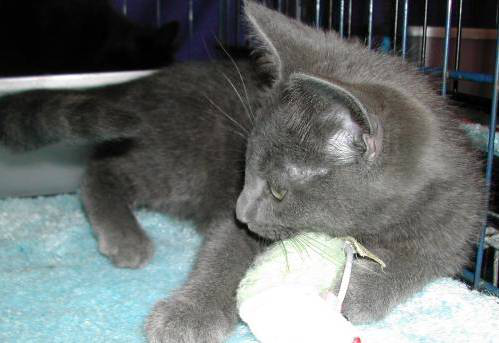

In [15]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [16]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [17]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [18]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [19]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [20]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 1727 correct labels


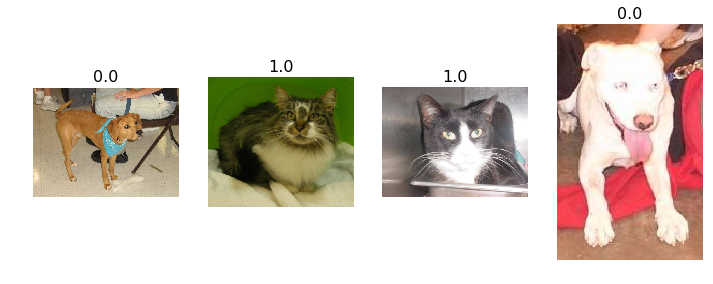

In [21]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 273 incorrect labels


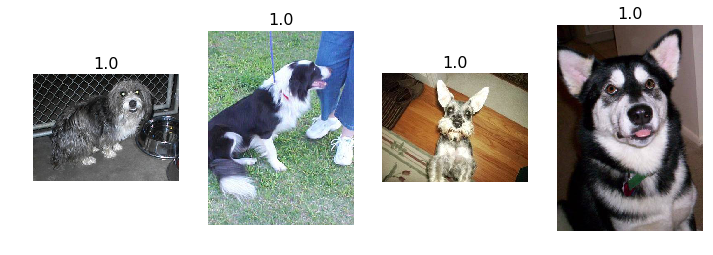

In [22]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 1006 confident correct cats labels


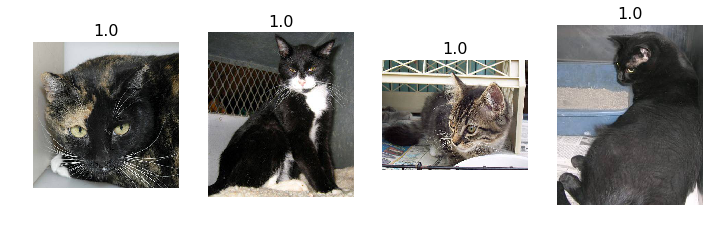

In [23]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print("Found %d confident correct cats labels" % len(correct_cats))
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 721 confident correct dogs labels


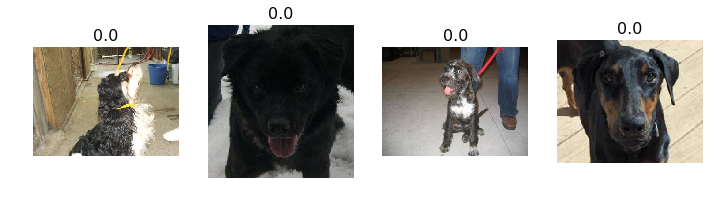

In [24]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print("Found %d confident correct dogs labels" % len(correct_dogs))
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 242 incorrect cats


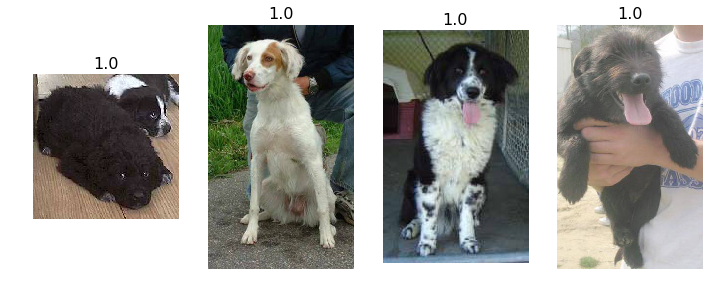

In [25]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print("Found %d incorrect cats" % len(incorrect_cats))
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 31 incorrect dogs


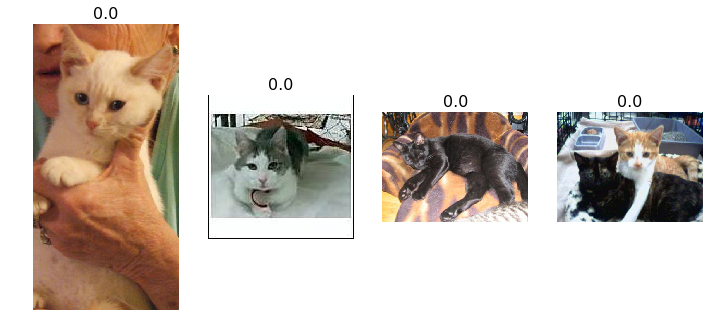

In [26]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print("Found %d incorrect dogs" % len(incorrect_dogs))
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

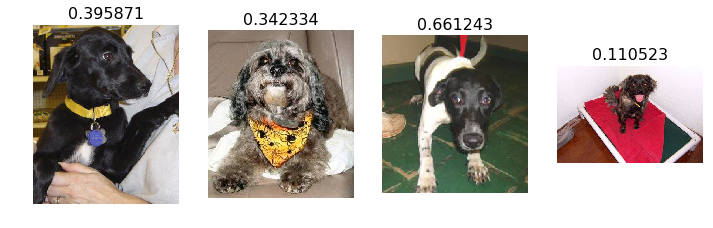

In [27]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[1006   31]
 [ 242  721]]


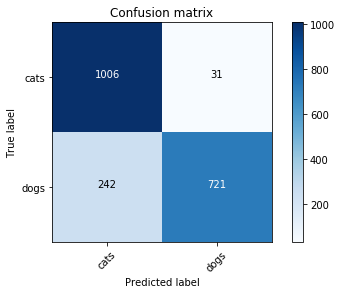

In [29]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit Predictions to Kaggle!

Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [30]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [31]:
#Grab the dog prediction column
isdog = preds[:,1]
print("Raw Predictions: " + str(isdog[:5]))
print("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Raw Predictions: [ 1.  0.  0.  1.  1.]
Mid Predictions: [ 0.4487  0.4939  0.5387]
Edge Predictions: [ 1.  0.  0. ...,  1.  0.  0.]


[Log Loss](http://wiki.fast.ai/index.php/Log_Loss) doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

In [32]:
expected_labels

array([0, 0, 0, ..., 1, 1, 1])

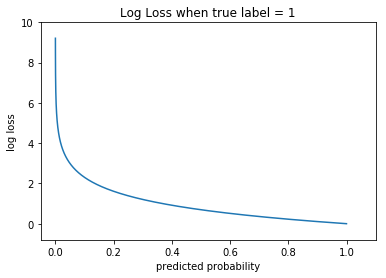

In [33]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
class_labels = [0,1] # 0=cats, 1=dogs
x = [1-(i*.0001) for i in range(1,10000)]  # probability of a dog
y = [log_loss(y_true=[1],y_pred=[[i*.0001,1-(i*.0001)]],eps=1e-15,labels=[0,1]) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [34]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [35]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

Here we join the two columns into an array of [imageId, isDog]

In [36]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  1.0000e+00,   9.5000e-01],
       [  1.0000e+01,   5.0000e-02],
       [  1.0000e+02,   5.0000e-02],
       [  1.0000e+03,   9.5000e-01],
       [  1.0000e+04,   9.5000e-01]])

In [37]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

F:\tools\projects\fast.ai.learning\lesson1\data\redux


In [38]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data\\redux\\'+submission_file_name)

F:\tools\projects\fast.ai.learning\lesson1


F:\tools\projects\fast.ai.learning\lesson1\data\redux\submission1.csv

You can download this file and submit on the Kaggle website or use the Kaggle command line tool's "submit" method.